# Final Project: Facial Recognition

##### This project is face recognition

## CS445: Computational Photography - Kayson Ijisesan

In [253]:
# Imports
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
import os


In [254]:
# data and output allocation
datadir = r"C:\Users\ijise\Desktop\cs445\projectf\Face Recognition"

datafn = os.path.join(datadir, "data")
outputfn = os.path.join(datadir, "output")
facesfn = os.path.join(datafn, "faces")
closeups = os.path.join(datafn, "closeups")


## Part 1: Integral Images

#### Integral pictures (also known as Summed Area Tables) are a method of processing an image that makes a fast calculation of the sum of pixel intensities across any rectangular region. This is especially useful in situations like object recognition, which need to analyze many overlapping areas quickly.

##### Each pixel in the picture is the sum of all pixel intensities in the rectangle from the top-left corner (0, 0) to the pixel (x, y) in the original image.
##### Using the picture, the sum of pixel intensities for each rectangular region can be calculated using only four array visits and basic calculations.

In [255]:
# choosing random image from input folder
faces = [face for face in os.listdir(closeups) if face.lower().endswith(('.png', '.jpg', '.jpeg'))]

random_face = random.choice(faces)
closeups1 = os.path.join(closeups, random_face)
img = cv2.imread(closeups1, cv2.IMREAD_GRAYSCALE)

In [256]:
def compute_integral(img):
    """
    Compute the integral image of a given image.

    Input:
        img (numpy.ndarray): Input image.

    Output:
        numpy.ndarray: Integral image.
    """

    rows, cols = img.shape
    integral_img = np.zeros((rows + 1, cols + 1), dtype=np.int32)
    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            integral_img[i, j] = (
                img[i-1, j-1]
                + integral_img[i-1, j]
                + integral_img[i, j-1]
                - integral_img[i-1, j-1]
            )
    return integral_img

integral_img1 = compute_integral(img)


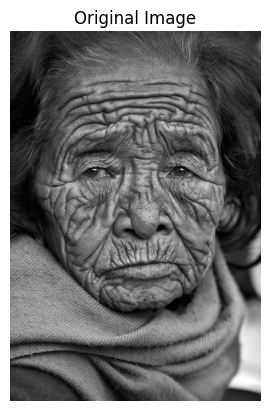

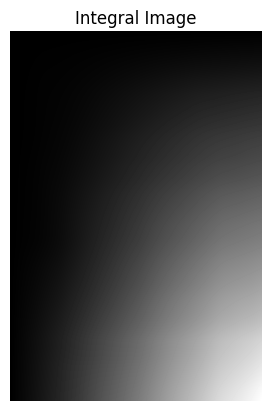

In [257]:
#Display
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


plt.imshow(integral_img1, cmap="gray")
plt.title("Integral Image")
plt.axis("off")
plt.show()


##### It has higher values (brighter) as you move toward the bottom-right corner of the image because pixel sums are accumulating.

## Part 2: Haar-Like Features

#### Haar-like features are used in face detection algorithms for recognize edges, lines, and texture patterns within an image. These features are computed using the integral image for fast calculation.

In [258]:
# choosing random image from input folder
random_face2 = random.choice(faces)
closeups2 = os.path.join(closeups, random_face2)
img2 = cv2.imread(closeups2, cv2.IMREAD_GRAYSCALE)

In [259]:
def compute_haar(integral_img, x, y, w, h, feature_type):
    """
    Compute Haar feature for a given region.

    Input:
        integral_img (numpy.ndarray): The integral image.
        x, y (int): Top-left coordinates of region.
        w, h (int): Width and height of region.
        feature_type (str): Type of feature .

    Output:
        Haar feature value.
    """

    if feature_type == "edge":
        left = integral_img[y, x] - integral_img[y + h, x] + integral_img[y + h, x + w // 2] - integral_img[y, x + w // 2]
        right = integral_img[y, x + w // 2] - integral_img[y + h, x + w // 2] + integral_img[y + h, x + w] - integral_img[y, x + w]
        return right - left
    elif feature_type == "line":
        top = integral_img[y, x] - integral_img[y + h // 2, x] + integral_img[y + h // 2, x + w] - integral_img[y, x + w]
        bottom = integral_img[y + h // 2, x] - integral_img[y + h, x] + integral_img[y + h, x + w] - integral_img[y + h // 2, x + w]
        return bottom - top
    else:
        raise ValueError("Error not a feature.")


In [260]:
def visualize_haar(img, x, y, w, h, feature_type):
    """
    Visualize Haar-like features on the image.

    Inputs:
        img (numpy.ndarray): Original image
        x, y (int): Top-left coordinates of region.
        w, h (int): Width and height of region.
        feature_type (str): Type of feature 
    """
    img_copy = img.copy()

    color1, color2 = (255, 0, 0), (0, 0, 255)  
    thickness = 6

    if feature_type == "edge":
        cv2.rectangle(img_copy, (x, y), (x + w // 2, y + h), color1, thickness)
        cv2.rectangle(img_copy, (x + w // 2, y), (x + w, y + h), color2, thickness)

    elif feature_type == "line":
        cv2.rectangle(img_copy, (x, y), (x + w, y + h // 3), color1, thickness)
        cv2.rectangle(img_copy, (x, y + h // 3), (x + w, y + 2 * h // 3), color2, thickness)
        cv2.rectangle(img_copy, (x, y + 2 * h // 3), (x + w, y + h), color1, thickness)
    
    # Display
    plt.imshow(img_copy, cmap="gray")
    plt.title(f"Haar Feature ({feature_type})")
    plt.axis("off")
    plt.show()

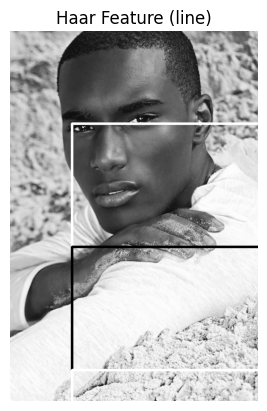

In [261]:
# region and feature type
h, w = img2.shape
reg_w, reg_h = w // 2, h // 2
cen_x, cen_y = w // 2, h // 2
x, y = cen_x - reg_w // 2, cen_y - reg_h // 2

feature_line = "line"
feature_edge = "edge"

integral_img2 = compute_integral(img2)

# Compute Haar 
feature_value = compute_haar(integral_img2, x, y, reg_w, reg_h, feature_line)

feature_value = compute_haar(integral_img2, x, y, reg_w, reg_h, feature_edge)

# Visualize Haar feature
visualize_haar(img2, x, y, w, h, feature_line)



#### Line: Patterns with a bright regions bordering by two darker regions
##### Eyebrows and forehead
##### Eyes and cheeks
##### Mouth and chin

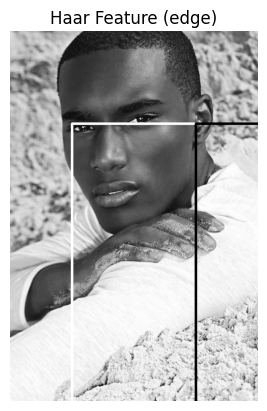

In [262]:
visualize_haar(img2, x, y, w, h, feature_edge)

#### Horizontal Edges: Transitions between light and dark regions along the vertical axis.
##### Forehead to eyebrows
##### Eyes to cheeks
##### Mouth to chin

#### Vertical Edges: Transitions between light and dark regions along the horizontal axis.
##### Nose to cheeks
##### Eyes to cheeks
##### Side of the face

## Part 3: Sliding Window

#### The sliding window method allows you to inspect small regions of an image and calculate characteristics for each region.

In [263]:
# choosing random image from input folder
random_face3 = random.choice(faces)
closeups3 = os.path.join(closeups, random_face3)
img3 = cv2.imread(closeups3, cv2.IMREAD_GRAYSCALE)

In [264]:
def sliding_window(img, integral_img, window_size, step_size, feature_type):
    """
    Sliding window to calc features.

    Inputs:
        img (numpy.ndarray): Original image 
        integral_img (numpy.ndarray): Integral 
        window_size (tuple): Size of the window 
        step_size (int): Number of pixels 
        feature_type (str): Type of feature

    Output:
        list: A list of features
            
    """
    rows, cols = img.shape
    window_w, window_h = window_size
    features = []

    # go through image
    for y in range(0, rows - window_h + 1, step_size):
        for x in range(0, cols - window_w + 1, step_size):
            # Haar  feature
            if y + window_h >= integral_img.shape[0] or x + window_w >= integral_img.shape[1]:
                continue 
            # calc Haar feature 
            haar_value = compute_haar(integral_img, x, y, window_w, window_h, feature_type)
            features.append(((x, y, window_w, window_h), haar_value))

    return features


In [265]:
def random_windows(img, features, window_size):
    """
    Visualize random set of sliding window 

    Input:
        img (numpy.ndarray): Original image 
        features (list): List of features
        window_size (tuple): Size of the sliding window
    """
    img_copy = img.copy()

    # Random feature
    random_features = random.sample(features, min(50, len(features)))

    # display windows
    for (x, y, w, h), _ in random_features:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.imshow(img_copy, cmap="gray")
    plt.title(f"Random Windows")
    plt.axis("off")
    plt.show()

In [266]:
def visualize_sliding_window(img, features):
    """
    Visualize sliding window result showing all region

    Input:
        img (numpy.ndarray): Original image 
        features (list): List of features computed 
    """
    img_copy = img.copy()

    # rectangles for all windows
    for (x, y, w, h), _ in features:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 1)

    plt.imshow(img_copy, cmap="gray")
    plt.title("Sliding Window")
    plt.axis("off")
    plt.show()

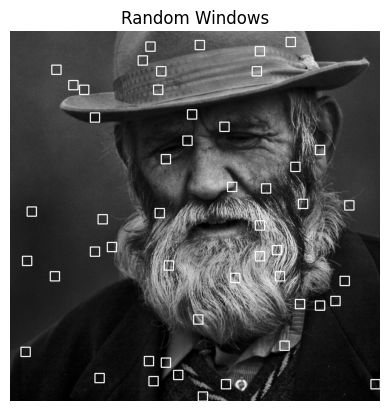

In [267]:
integral_img3 = compute_integral(img3)

window_size = (24, 24)
step_size = 4
feature_type = "edge"
features = sliding_window(img3, integral_img3, window_size, step_size, feature_type)

random_windows(img3, features, window_size)


#### Random selection of regions analyzed by the sliding window each rectangle corresponds to a region where the sliding window analyzed for Haar features

Number of windows found: 55225


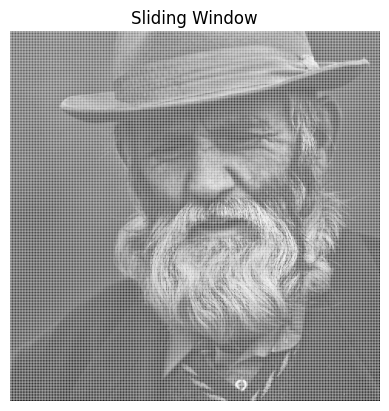

In [268]:
print(f"Number of windows found: {len(features)}")
visualize_sliding_window(img3, features)

#### Rectangles are overlaid on every region analyzed by the sliding window, each rectangle corresponds to a position where the sliding window computed for Haar features.

## Part 4: Detecting Key Compnents  

#### This step uses harr features to detect key features that are seen on faces

In [269]:
# choosing random image from input folder

random_face4 = random.choice(faces)
closeups4 = os.path.join(closeups, random_face4)
img4 = cv2.imread(closeups4, cv2.IMREAD_GRAYSCALE)

In [270]:
# harr feature to find eye-like features
def detect_eyes(image, scale_factor=1.05, min_neighbors=1, min_size=(15, 15)):
    """
    Calc Haar feature to detect eyes 

    Input:
        image (numpy.ndarray): Input image 
        scale_factor (float): Pyramid scale factor  
        min_neighbors (int): Minimum neighbors req
        min_size (tuple): Minimum size.

    Output:
        list: Detected eye regions
    """
   
    eye_det = cv2.CascadeClassifier("eye.xml")
    
    # contrast boost
    image = cv2.equalizeHist(image)

    # Detect eyes
    detected_eyes = eye_det.detectMultiScale(
        image,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )

    return detected_eyes


In [271]:

# harr feature to find better lines that represent significant face features
def detect_line(image, scale_factor=1.05, min_neighbors=10, min_size=(15, 15)):
    """
    Detect lines in image

    Parameters:
        image (numpy.ndarray): Input image 
        scale_factor (float): Pyramid scale factor
        min_neighbors (int): Minimum neighbors req
        min_size (tuple): Minimum size.

    Returns:
        list: Detected line regions
    """

    line_det = cv2.CascadeClassifier("line.xml")

    # Contrast boost
    image = cv2.equalizeHist(image)

    # Detect line
    detected_line = line_det.detectMultiScale(
        image,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )

    return detected_line


In [272]:
def compute_haar_feat(img, feature_type):
    """
    Compute Haar feature to detect eyes or line 

    Input:
        img (numpy.ndarray)  image for processing

    Output:
        list: Detected regions 
    """


    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    img = cv2.equalizeHist(gray_img)

    # feature type
    if feature_type == 'eyes':
        detected = detect_eyes(img)

    elif feature_type == 'line':
        detected = detect_line(img)
 

    return detected


Number of eyes features: 5


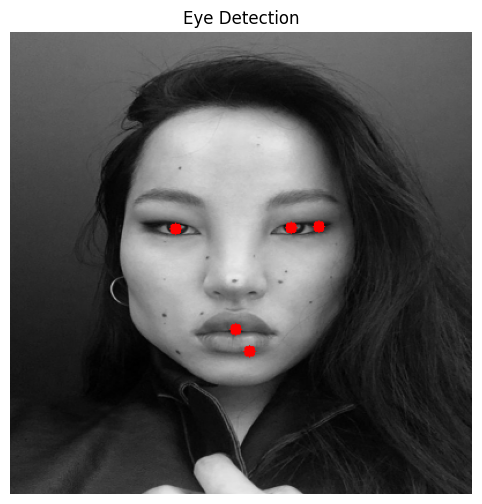

In [273]:
img4 = cv2.resize(img4, (400, 400), interpolation=cv2.INTER_AREA)

feature_type = "eyes"
eyes = compute_haar_feat(img4, feature_type)
print(f"Number of eyes features: {len(eyes)}")

img_copy = cv2.cvtColor(img4, cv2.COLOR_GRAY2BGR)

# red dots at eye 
for (x, y, w, h) in eyes:
    center_x = x + w // 2
    center_y = y + h // 2
    cv2.circle(img_copy, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)

# Display 
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Eye Detection")
plt.show()


Number of line features: 4


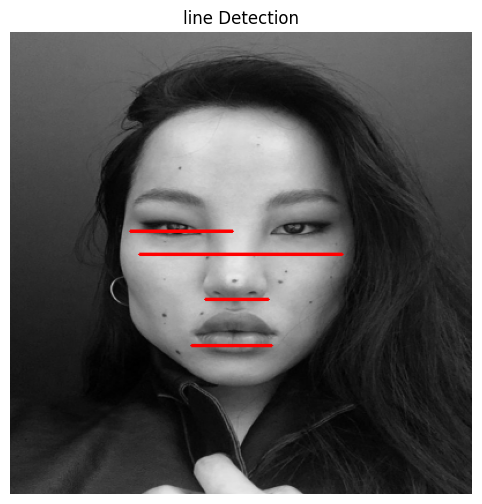

In [274]:

img4 = cv2.resize(img4, (400, 400), interpolation=cv2.INTER_AREA)

feature_type = "line"
line = compute_haar_feat(img4, feature_type)
print(f"Number of line features: {len(line)}")

img_copy = cv2.cvtColor(img4, cv2.COLOR_GRAY2BGR)

for (x, y, w, h) in line: #lines 
        line_y = y + h // 2
        cv2.line(img_copy, (x, line_y), (x + w, line_y), (0, 0, 255), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("line Detection")
plt.show()

## Part 5: Filtering & Combining Key Compnents  

#### Connect key components to build face and detect face

In [275]:
def adjust_face_box(face_x, face_y, face_w, face_h, img_width, img_height):
    """
    Adjust the face box to ensure it fits in the boundaries

    Input:
        face_x (int): The x-coordinate of the top-left corner of the face box
        face_y (int): The y-coordinate of the top-left corner of the face box
        face_w (int): The width of the face box
        face_h (int): The height of the face box
        img_width (int): The width of the image 
        img_height (int): The height of the image 

    Output:
        tuple: Adjusted face bounding box
    """
    face_x = max(0, face_x)
    face_y = max(0, face_y)
    face_w = min(face_w, img_width - face_x)
    face_h = min(face_h, img_height - face_y)
    return face_x, face_y, face_w, face_h


In [276]:
def filter_line(detected_line, avg_eye_height, line_padding):
    """
    Filter lines
    Input:
        detected_line (list): List of detected line
        avg_eye_height (int or float): average height of detected eyes 
        line_padding (int): padding added below the average eye height 
                        
    Output:
        list: Filtered line boxes 
    """
    return [
        (mx, my, mw, mh)
        for (mx, my, mw, mh) in detected_line
        if (my + mh // 2) > (avg_eye_height + line_padding)
    ]

In [277]:
def identify_face(detected_eyes, img_shape, detected_line=None, horizontal_thresh=200, vertical_thresh=20, min_horizontal_dist=10, line_padding=30, extra_padding_above_eyes=50,  extra_padding_below_line=50):
    """
    Identify a face based on detected eyes detected lines.

    Input:
        detected_eyes (list): List of detected eyes
        img_shape (tuple): Shape of the input image
        detected_line (list): List of detected line boxes
        horizontal_thresh (int): Maximum horizontal distanc
        vertical_thresh (int): Maximum vertical misalignment 
        min_horizontal_dist (int): Minimum horizontal distance between two eyes
        line_padding (int): padding below the average eye height 
        extra_padding_above_eyes (int): padding added above the eyes
        extra_padding_below_line (int): padding added below detected line for the face

    Output:
        tuple:
            - faces (list): List of detected face boxes
            - selected_eyes (list): List of the two eyes
            - detected_line (list): List of filtered line  boxes 
    """
    height, width = img_shape
    center_x_line = width / 2

    if len(detected_eyes) < 2:
        return [], [], []

    # Filter eyes 
    candidates = []
    for i, (x1, y1, w1, h1) in enumerate(detected_eyes):
        for j, (x2, y2, w2, h2) in enumerate(detected_eyes):
            if i >= j:  # dont use duplicate pairs
                continue

            # centers and distances
            eye1_center_x = x1 + w1 // 2
            eye1_center_y = y1 + h1 // 2
            eye2_center_x = x2 + w2 // 2
            eye2_center_y = y2 + h2 // 2

            vertical_dist = abs(eye1_center_y - eye2_center_y)
            horizontal_dist = abs(eye1_center_x - eye2_center_x)

            # filtering thresholds
            if (
                vertical_dist <= vertical_thresh and
                horizontal_dist >= min_horizontal_dist and
                horizontal_dist <= horizontal_thresh
            ):
                avg_eye_center_x = (eye1_center_x + eye2_center_x) / 2
                avg_eye_height = (eye1_center_y + eye2_center_y) / 2

                # closeness to center and line
                line_dist = float('inf')
                if detected_line is not None and len(detected_line) > 0:
                    line_center_x = detected_line[0][0] + detected_line[0][2] // 2
                    line_center_y = detected_line[0][1] + detected_line[0][3] // 2
                    line_dist = abs(line_center_x - avg_eye_center_x)

                dist_from_center = abs(avg_eye_center_x - center_x_line)

                candidates.append({
                    'eyes': ((x1, y1, w1, h1), (x2, y2, w2, h2)),
                    'vertical_dist': vertical_dist,
                    'horizontal_dist': horizontal_dist,
                    'line_dist': line_dist,
                    'dist_from_center': dist_from_center,
                    'avg_eye_center_x': avg_eye_center_x,
                    'avg_eye_height': avg_eye_height,
                })

    if not candidates:
        return [], [], []

    # priority: vertical_dist, line_dist, dist_from_center
    candidates.sort(key=lambda c: (c['vertical_dist'], c['line_dist'], c['dist_from_center']))

    # best pair of eyes
    best_pair = candidates[0]['eyes']
    avg_eye_center_x = candidates[0]['avg_eye_center_x']
    avg_eye_height = candidates[0]['avg_eye_height']

    # Filter lines
    detected_line = (
        filter_line(detected_line, avg_eye_height, line_padding)
        if detected_line is not None and len(detected_line) > 0
        else []
    )

    # longest line
    if detected_line:
        detected_line = [max(detected_line, key=lambda m: m[2])]

    # face box
    (x1, y1, w1, h1), (x2, y2, w2, h2) = best_pair
    face_width = abs(x2 - x1) + max(w1, w2)

    if detected_line:
        (mx, my, mw, mh) = detected_line[0]
        line_center_x = mx + mw // 2
        line_center_y = my + mh // 2

        face_x = int(line_center_x - face_width // 2)
        face_y = int(avg_eye_height - extra_padding_above_eyes)
        face_h = int((line_center_y + extra_padding_below_line) - face_y)
    else:
        face_x = int(avg_eye_center_x - face_width // 2)
        face_y = int(avg_eye_height - extra_padding_above_eyes)
        face_h = int(face_width * 1.5)

    #bounds
    face_x, face_y, face_width, face_h = adjust_face_box(face_x, face_y, face_width, face_h, width, height)
    faces = [(face_x, face_y, face_width, face_h)]

    return faces, [tuple(map(int, best_pair[0])), tuple(map(int, best_pair[1]))], detected_line


In [278]:
def face_detect(img, faces, eyes, lines=None):
    """
    Display faces, eyes, and lines on the image.

    Input:
        img (numpy.ndarray): input image 
        faces (list): List of detected face boxes
        eyes (list): List of detected eye boxes 
        lines (list): List of detected line boxes 

    Output:
        img:
              - Red circles marking the center of detected eyes
              - Blue lines representing detected lines 
              - Green rectangles marking detected faces
    """
    if len(img.shape) == 2:
        img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_copy = img.copy()

    # Draw eyes
    for (x, y, w, h) in eyes:
        center_x = x + w // 2
        center_y = y + h // 2
        cv2.circle(img_copy, (center_x, center_y), 5, (0, 0, 255), -1)

    # Draw lines
    if lines:
        for (x, y, w, h) in lines:
            line_line_y = y + h // 2
            cv2.line(img_copy, (x, line_line_y), (x + w, line_line_y), (255, 0, 0), 2)

    # Draw face box
    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Face")
    plt.show()

    return img_copy


Detected eyes: [[116 143  54  54]
 [194 263  27  27]
 [243 144  49  49]
 [216 142  55  55]
 [163 225  65  65]]
Detected line: [[169 215  54  32]
 [104 146  88  53]
 [157 250  69  42]
 [112 140 175 105]]


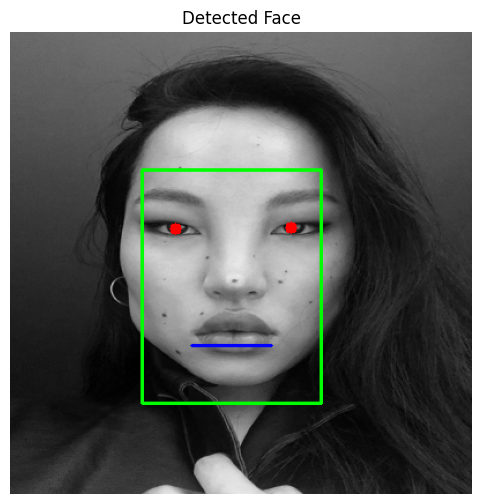

In [279]:
# Detect eyes
detected_eyes = compute_haar_feat(img4, feature_type='eyes')
print(f"Detected eyes: {detected_eyes}")

# Detect line
detected_line = compute_haar_feat(img4, feature_type='line')
print(f"Detected line: {detected_line}")

# Identify face
faces, selected_eyes, detected_line = identify_face(
    detected_eyes, 
    img4.shape, 
    detected_line=detected_line, 
    horizontal_thresh=500, 
    vertical_thresh=20, 
    min_horizontal_dist=10
)

if not faces:
    print("Face not detected")
else:
    # Display
    face_detect(img4, faces, selected_eyes, detected_line)


No face detected in image0: [[ 0  0  0 ... 58 60 17]
 [ 0  0  0 ... 81 70 54]
 [ 0  0  0 ... 63 78 60]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


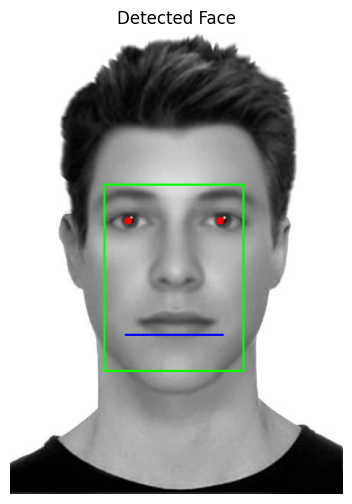

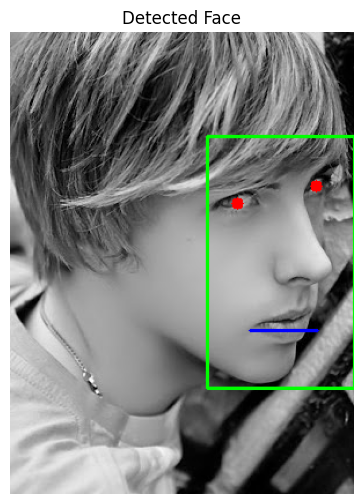

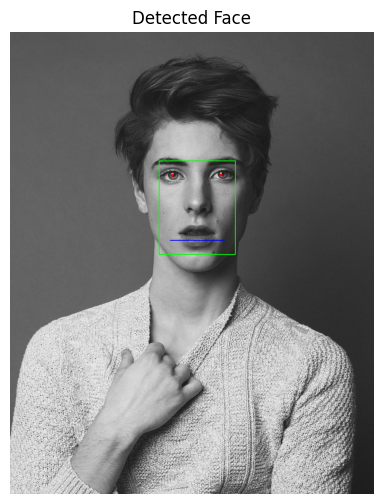

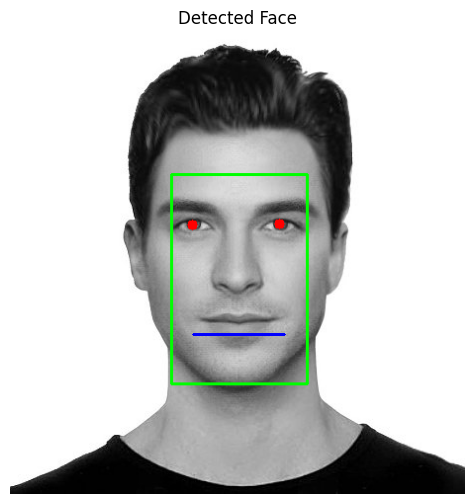

No face detected in image5: [[48 53 49 ... 39 39 39]
 [42 46 42 ... 34 34 35]
 [37 39 34 ... 36 36 36]
 ...
 [33 32 31 ... 33 32 32]
 [36 36 36 ... 34 34 33]
 [42 44 46 ... 35 34 34]]


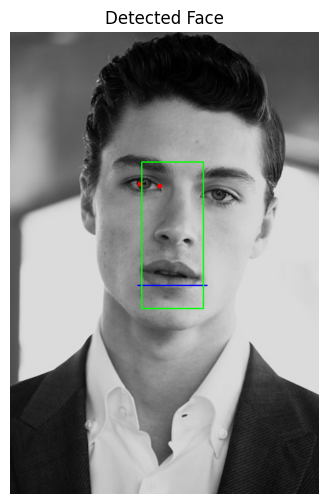

No face detected in image7: [[108 110 112 ...  57  50  43]
 [109 110 112 ...  55  49  42]
 [109 111 112 ...  55  50  43]
 ...
 [ 80  84  90 ...  77  71  63]
 [ 80  84  90 ...  78  72  64]
 [ 80  84  90 ...  79  73  65]]


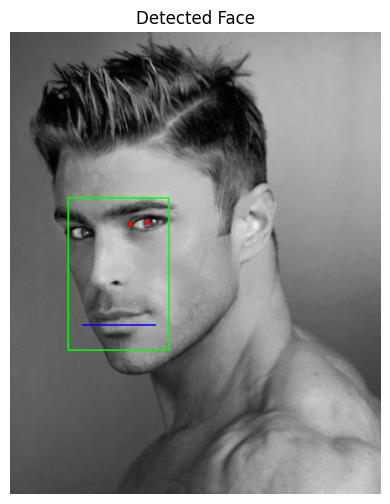

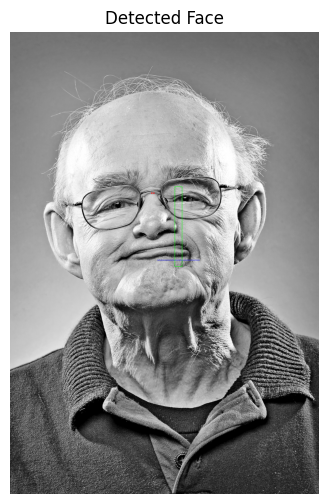

In [280]:
input_folder = closeups
output_folder = os.path.join(datafn, "output")

#output folder 
os.makedirs(output_folder, exist_ok=True)

images = [img for img in os.listdir(input_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# random images
for i in range(10): 

    random_image = random.choice(images)
    image_path = os.path.join(input_folder, random_image)
    img5 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    
    # Detect eyes
    detected_eyes = compute_haar_feat(img5, feature_type='eyes')

    # Detect line
    detected_line = compute_haar_feat(img5, feature_type='line')

    # Identify faces 
    faces, selected_eyes, detected_line = identify_face(
        detected_eyes,
        img5.shape,
        detected_line=detected_line,
        horizontal_thresh=500,
        vertical_thresh=20,
        min_horizontal_dist=10
    )

    if not faces:
        print(f"No face detected in image{i}: {img5}")
        continue
    newim5 = face_detect(img5, faces, selected_eyes, detected_line)

    output_path = os.path.join(output_folder, random_image)
    cv2.imwrite(output_path, newim5)